In [2]:
import os
import pandas as pd

from constants import *

# Analyse du biais 

In [3]:
#original contains the original string and the corrected string 
original = pd.read_csv(MANUAL_TRANSCRIPTION)
original = original[["annee","chef_vocation", "chef_vocation_transcripted", "pensionnaires_condition", "pensionnaires_condition_transcripted"]]

cols = ["chef_vocation","chef_vocation_transcripted","pensionnaires_condition","pensionnaires_condition_transcripted"]
original[cols] = original[cols].fillna("") \
                                .apply(lambda serie: serie.apply(lambda s: s.replace("·","").split('|')))
original = original.fillna("").replace("NSP","")

manual_transcription = original[['annee','chef_vocation_transcripted','pensionnaires_condition_transcripted']]\
.rename(columns = {'chef_vocation_transcripted':'chef_vocation','pensionnaires_condition_transcripted':'pensionnaires_condition'})

manual_transcription


,annee,chef_vocation,pensionnaires_condition
0,1848,[],[]
1,1848,[conservateur],[pensionnaire]
2,1848,[boulanger],[]
3,1848,[tailleuse],"[ouvriere, apprentie]"
4,1848,[relieur],[]
...,...,...,...
518,1868,[marchand de tamis],[]
519,1868,[rentiere],[arpenteur]
520,1868,[charcutier],[domestique]
521,1868,[macon],[pensionnaire]


In [4]:
from ast import literal_eval

#All the data processed through the automatic correction pipeline => keep also the words that are not correct
automatic_correction = pd.read_csv(CORRECTED_RAW_DATA)
automatic_correction = automatic_correction[["annee","chef_vocation","pensionnaires_condition"]]
automatic_correction[["chef_vocation","pensionnaires_condition"]] = automatic_correction[["chef_vocation","pensionnaires_condition"]].applymap(literal_eval)
automatic_correction = automatic_correction.fillna("").replace("NSP","")
automatic_correction

,annee,chef_vocation,pensionnaires_condition
0,1835,[rocureur],[pensre friere se]
1,1835,[pintier],[pensionnaire]
2,1835,[boulanger],[ouvrier]
3,1835,[voiturier],[penvre]
4,1835,[marechat],"[ouvrier, ouvrier]"
...,...,...,...
378721,1898,[chay l],[]
378722,1898,[meme maison],[]
378723,1898,[monimier],[]
378724,1898,[ontumineur],[]


In [5]:
manual_transcription_1848 = manual_transcription[manual_transcription["annee"]==1848]
manual_transcription_1868 = manual_transcription[manual_transcription["annee"]==1868]

original_1848 = original[original["annee"]==1848]
original_1868 = original[original["annee"]==1868]

automatic_correction_1848 = automatic_correction[automatic_correction["annee"]==1848]
automatic_correction_1868 = automatic_correction[automatic_correction["annee"]==1868]

automatic_correction_1848 = automatic_correction_1848.iloc[:len(manual_transcription_1848)]
automatic_correction_1868 = automatic_correction_1868.iloc[:len(manual_transcription_1868)]

print(len(manual_transcription_1848))
print(len(automatic_correction_1848))

274
274


### Word length analysis

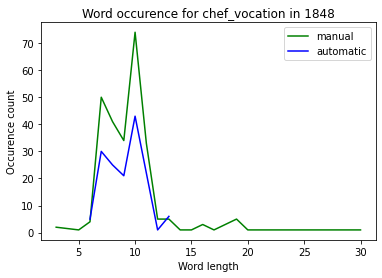

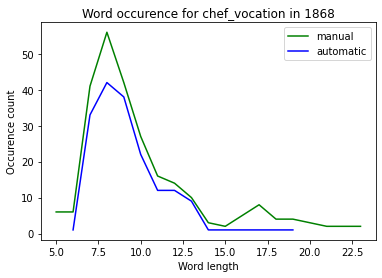

In [10]:
import matplotlib.pyplot as plt

kept_terms = set(pd.read_csv(CORRECT_JOBS)["0"])

def word_length_distribution(col,only_keep_terms=False):
    new_col = col.explode()
    if(only_keep_terms):
        new_col = new_col[new_col.isin(kept_terms)]
    new_col = new_col.apply(lambda s: len(s))
    
    value_counts = new_col.value_counts().sort_index()
    #Remove 0 size values
    value_counts = value_counts.drop(value_counts.index[0],axis='index')
    return value_counts

def plot_word_length(manual,automatic,title):
    word_length_manual = word_length_distribution(manual)
    word_length_automatic = word_length_distribution(automatic,only_keep_terms=True)
    
    plt.plot(word_length_manual,color='green', label='manual')
    plt.plot(word_length_automatic,color='blue', label='automatic')
    plt.xlabel('Word length')
    plt.ylabel('Occurence count')
    plt.title(title)
    plt.legend()
    plt.show()
    
plot_word_length(manual_transcription_1848['chef_vocation'],
                 automatic_correction_1848['chef_vocation']
                 ,title="Word occurence for chef_vocation in 1848")

plot_word_length(manual_transcription_1868['chef_vocation'],
                 automatic_correction_1868['chef_vocation']
                 ,title="Word occurence for chef_vocation in 1868")

**Discussion** As we can see, the automatic correction does not correct long words, this is due to the selection of the top 100 most frequent words bias and the fact that long words are less frequent and also that the OCR might make more mistakes on long words words 

### Distribution similarity

In [11]:
from collections import Counter

def count_jobs(df,col_name,only_keep_terms=False):
    jobs = df[col_name].explode()
    if(only_keep_terms):
        jobs=jobs[jobs.isin(kept_terms)]
        
    jobs = jobs[jobs!='']
    job_counts = jobs.value_counts()
    job_counts = job_counts.to_frame().reset_index()
    
    return job_counts.rename(columns = {'index':col_name, col_name:'count'},inplace=False)

def compute_difference(df1,df2,col_name,only_keep_terms=False):
    job_counts1=count_jobs(df1,col_name,only_keep_terms)
    job_counts2=count_jobs(df2,col_name,only_keep_terms)
    job_counts = pd.merge(job_counts1, job_counts2, how='outer',left_on = 'chef_vocation', right_on='chef_vocation').fillna(0)
    job_counts['diff'] = (job_counts['count_x']-job_counts['count_y']).abs()
    #Divide by 2 because all differences are computed twice
    return job_counts['diff'].sum()

def compute_accuracy(df_pred,df_true,col_name,only_keep_terms=False):
    true_counts = count_jobs(df_true,col_name,only_keep_terms)['count'].sum()
    diff = compute_difference(df_pred,df_true,col_name,only_keep_terms)/2
    return (true_counts-diff)/true_counts

In [12]:
print(compute_accuracy(manual_transcription_1848,manual_transcription_1848,'chef_vocation',only_keep_terms=True))
print(compute_accuracy(manual_transcription_1848,original_1848,'chef_vocation',only_keep_terms=True))
print(compute_accuracy(manual_transcription_1848,automatic_correction_1848,'chef_vocation',only_keep_terms=True))

1.0
0.6029411764705882
0.7012987012987013


In [13]:
print(compute_accuracy(manual_transcription_1868,manual_transcription_1868,'chef_vocation',only_keep_terms=True))
print(compute_accuracy(manual_transcription_1868,original_1868,'chef_vocation',only_keep_terms=True))
print(compute_accuracy(manual_transcription_1868,automatic_correction_1868,'chef_vocation',only_keep_terms=True))

1.0
0.8509316770186336
0.903954802259887


In [14]:
print(len(manual_transcription_1868))
print(len(manual_transcription_1848))

249
274


In [15]:
((compute_accuracy(manual_transcription_1868,original_1868,'chef_vocation',only_keep_terms=True) * len(manual_transcription_1868)
+ compute_accuracy(manual_transcription_1848,original_1848,'chef_vocation',only_keep_terms=True) * len(manual_transcription_1848))/(len(manual_transcription_1868)+ len(manual_transcription_1848)))

0.7210093115307475

In [16]:
((compute_accuracy(manual_transcription_1868,automatic_correction_1868,'chef_vocation',only_keep_terms=True) * len(manual_transcription_1868)
+ compute_accuracy(manual_transcription_1848,automatic_correction_1848,'chef_vocation',only_keep_terms=True) * len(manual_transcription_1848))/(len(manual_transcription_1868)+ len(manual_transcription_1848)))

0.7977831547199924